<a href="https://colab.research.google.com/github/CECILIACFR/DATASCIENCE/blob/main/MVP_Sprint_II_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  MVP de Deep Learning - Parte (b)

## Professores: Augusto Baffa, Hélio Lopes, Luiz Schirmer, Jonatas Grosman, e Hugo Villamizar.
## Aluna: Cecília Corrêa Ferrari Rey
### MVP de Classificação de Sentimentos com Redes Neurais Convolucionais (Data: julho/2023)

#0.Definição do Problema

O objetivo deste trabalho é desenvolver modelo de deep learning de **Classificação de Sentimentos de Publicações ("Tweets")** extraídas da rede social **Twitter**, postadas pelos seus usuários, para predizer se a publicação é Positiva ou Negativa.  O dataset contém textos em inglês.

**Informação dos atributos:**

1.  **sentiment**: O sentimento pode ser Negativo (Classe 0), Neutro (Classe 2) ou Positivo (Classe 4);
2.  **id**: identificação do usuário;
3.  **date**: data da publicação do "tweet";
4.  **query**: pergunta do "tweet";
5.  **user**: nome do usuário do "tweet";
6.  **text**: texto do "tweet" postado pelo usuário.


#1.Importação das bibliotecas






In [ ]:
# Configuração para não exibir os warnings
# import warnings
# warnings.filterwarnings("ignore")

In [ ]:
!pip install gdown
import gdown
import os
import zipfile

import numpy as np
import math
import re # For preprocessing
import pandas as pd #For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
from bs4 import BeautifulSoup
import seaborn as sns
import spacy as sp # For preprocessing
import string
import random
import matplotlib.pyplot as plt

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


In [ ]:
!python3 -m spacy download en_core_web_sm
from spacy.lang.en.examples import sentences

2023-07-17 03:25:55.334239: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 9.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.12.0'

In [ ]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

#2.Pré-processamento dos dados

##2.1.Carregamento dos arquivos

In [ ]:
file_id = "1Z0Ean7NBeOwiBulKkyHs9Vau95SVUOBy"
url = f"https://drive.google.com/uc?id={file_id}"

folder_path = "./"  # especifique a pasta onde baixara o arquivo
os.makedirs(folder_path, exist_ok=True) # cria a pasta de destino se necessário

output = "trainingandtestdata.zip"  # especifique o nome do arquivo e a extensão do mesmo
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1Z0Ean7NBeOwiBulKkyHs9Vau95SVUOBy
To: /content/trainingandtestdata.zip
100%|██████████| 85.1M/85.1M [00:01<00:00, 48.2MB/s]


'trainingandtestdata.zip'

In [ ]:
destination = './' # path onde se encontra o arquivo 'trainingandtestdata.zip'

os.makedirs(destination,exist_ok=True) # cria a pasta de destino se necessário

with zipfile.ZipFile(output,'r') as zip_ref:
    zip_ref.extractall(destination)

In [ ]:
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [ ]:
# Carregando o dataset em um DataFrame
train_data = pd.read_csv('/content/trainingandtestdata/train.csv', header = None,
                         names = cols, engine = 'python', encoding = 'latin1')

In [ ]:
train_data.shape

(1600000, 6)

In [ ]:
train_data.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
train_data.tail()

,sentiment,id,date,query,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [ ]:
train_data.sentiment.unique()

array([0, 4])

O dataset 'train_data' (**base de treino**) possui apenas sentimentos (coluna "Sentiment") Negativos (Classe 0) e Positivos (Classe 4).

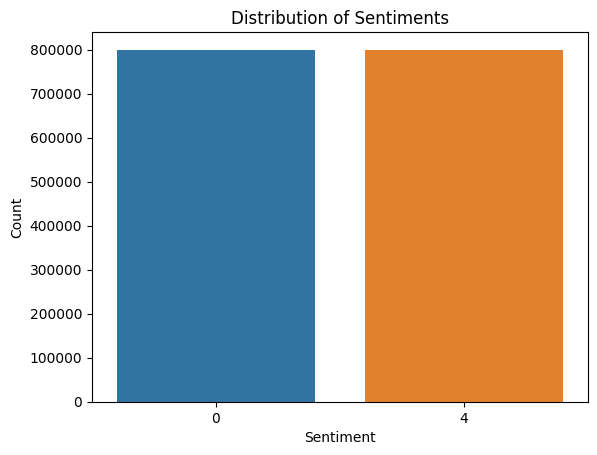

In [ ]:
sns.countplot(data=train_data, x='sentiment')

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

# Show the plot
plt.show()

O Gráfico acima indica a quantidade de sentimentos (coluna "Sentiment") Negativos (Classe 0) e Positivos (Classe 4) da **base de treino**, demonstrando não estar desbalanceada, já que possui a mesma quantidade para cada sentimento.

In [ ]:
test_data = pd.read_csv("/content/trainingandtestdata/test.csv",
    header=None,
    names=cols,
    engine="python",
    encoding="latin1"
)

In [ ]:
test_data.head()

,sentiment,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [ ]:
test_data.shape

(498, 6)

In [ ]:
test_data.sentiment.unique()

array([4, 0, 2])

O dataset 'test_data' (**base de teste**) possui sentimentos (coluna "Sentiment") Negativos (Classe 0), Neutros (Classe 2) e Positivos (Classe 4). Esta base de teste possui uma Classe a mais que a base de treino, e **por isso motivo a base de testes não será usada**.

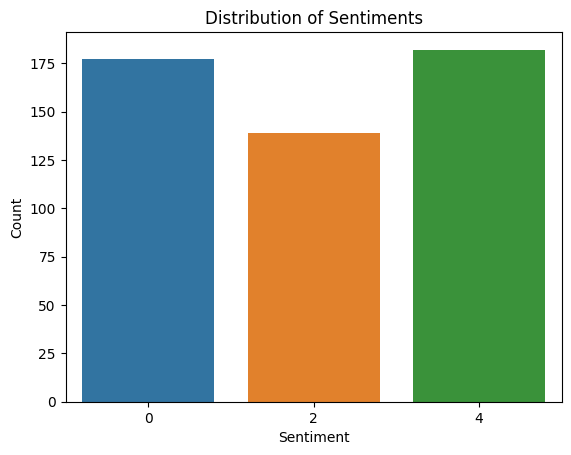

In [ ]:
sns.countplot(data=test_data, x='sentiment')

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

# Show the plot
plt.show()

*O* Gráfico acima indica a quantidade de sentimentos (coluna "Sentiment") Negativos (Classe 0), Neutros (Classe 2) e Positivos (Classe 4) da **base de teste**. Vale ressaltar, que a **base de treino** possui zero (0) registros de sentimentos (Coluna "Sentiment") Neutros (Classe 2).


##2.2.Pré-processamento

###2.2.1.Limpeza

In [ ]:
data = train_data

In [ ]:
data.drop(['id', 'date', 'query', 'user'], axis = 1, inplace=True)

As colunas ['id'], ['date'], ['query'] e ['user']) do dataset "data" (**base de treino**) estão sendo exclúidas, pois elas não são importantes para o estudo em questão.

In [ ]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


O dataset "data" (**base de treino**) consta agora somente com as duas colunas: ['sentiment'] e ['text'].

In [ ]:
X = data.iloc[:, 1].values

In [ ]:
X

array(["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
       "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
       '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
       ..., 'Are you ready for your MoJo Makeover? Ask me for details ',
       'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur ',
       'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H '],
      dtype=object)

In [ ]:
X.shape

(1600000,)

In [ ]:
type(X)

numpy.ndarray

In [ ]:
y = data.iloc[:, 0].values
y

array([0, 0, 0, ..., 4, 4, 4])

In [ ]:
from sklearn.model_selection import train_test_split
X, _, y, _ = train_test_split(X, y, test_size = 0.85, stratify = y)

In [ ]:
y.shape

(240000,)

In [ ]:
X.shape

(240000,)

O comando **train_test_split** logo acima, divide o conjunto de dados original em conjuntos de **treinamento e teste**. No entanto, o uso de "_" no código indica que não está sendo atribuído valores a esses variáveis, ou seja, não está armazenando as partes descartadas dos dados.
O parâmetro 0.85 usado para **test_size** neste referido comando, indica que 85% dos dados serão atribuídos ao conjunto de teste, enquanto 15% serão atribuídos ao conjunto de treinamento. Neste caso, a base de treino ficou com 240.000 mil registros, que è 15% da quantidade original da base (1.600.000 mil registros), e 85% da base original que iriam para base de teste foram descartados.


In [ ]:
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 4]), array([120000, 120000]))

O dataset **y** (target) possui  a mesma quantidade para cada sentimento (coluna "Sentiment"): 120.000 mil registros de Negativo (Classe 0) e 120.000 mil registros de Positivo (Classe 4), demonstrando **não estar desbalanceada**.

In [ ]:
def clean_tweets(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet)
  tweet = re.sub(r" +", ' ', tweet)
  return tweet

In [ ]:
text = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  2 You shoulda got David Carr of Third Day to do it. ;D"

In [ ]:
text = clean_tweets(text)
text

<ipython-input-35-77b6d4622bcb>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'lxml').get_text()


' Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D'

In [ ]:
# Carregar o pipeline em inglês do pacote spacy
sp.cli.download("en_core_web_sm")
nlp = sp.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed
#nlp = sp.load('en')

nlp

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
stop_words = sp.lang.en.STOP_WORDS

In [ ]:
print(stop_words)

{'done', 'again', 'others', 'amongst', 'front', 'everyone', 'thereby', 'behind', 'mostly', 'due', 'nevertheless', 'nine', 'namely', 'various', 'six', 'whereupon', 'whom', 'down', 'five', 'during', 'into', 'four', 'against', 'serious', 'amount', 'too', 'see', 'seem', 'both', 'until', 'say', 'to', 'whereafter', '‘ll', 'part', 'which', 'before', 'here', 'there', "'s", 'but', '’ll', 'for', 'moreover', 'or', 'while', 'whole', 'itself', 'hence', 'their', 'latter', "'m", 'whither', 'from', 'onto', 'above', 'therein', 're', 'my', 'whence', 'becomes', 'would', 'more', 'back', '’s', 'unless', 'on', 'whenever', 'still', 'nobody', 'two', '‘ve', '’ve', 'give', 'are', 'anywhere', 'same', 'become', 'became', 'former', 'together', 'not', 'someone', 'herein', 'quite', 'whereas', 'a', 'nothing', 'will', 'wherever', 'should', 'every', 'get', 'this', 'have', 'herself', 'since', 'ourselves', 'formerly', 'therefore', 'hereafter', 'used', 'through', 'were', 'already', 'except', 'keep', 'anyway', '‘re', 'may'

In [ ]:
len(stop_words)

326

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def clean_tweets2(tweet):
  tweet = tweet.lower()
  document = nlp(tweet)

  words = []
  for token in document:
    words.append(token.text)

  words = [word for word in words if word not in stop_words and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])

  return words

In [ ]:
#" Awww that's a bummer. You shoulda got David Carr of Third Day to do it. D"

In [ ]:
text2 = clean_tweets2(text)
text2

'  awww s bummer shoulda got david carr day d'

In [ ]:
data_clean = [clean_tweets2(clean_tweets(tweet)) for tweet in X]

<ipython-input-35-77b6d4622bcb>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'lxml').get_text()


In [ ]:
for _ in range(10):
  print(data_clean[random.randint(0, len(data_clean) - 1)])

hope finish project start run today
  worries thought worth mention!special offer buying tickets ruby s going shout
  m good morning
  darn seeing adam
beautiful day beautiful mia gon na good day
  s years old graduated kindergarten
  angels demons ... epic haha u rach
m missing baby luv
  actually create lot magic lol ... told loved
pool party tomorrow haha goodnights


In [ ]:
data_labels = y

In [ ]:
data_labels[data_labels == 4] = 1

Foram transformados todas as Classes de 4 em 1.




In [ ]:
data_labels

In [ ]:
np.unique(data_labels)

Os valores das Classes são agora apenas 0 e 1. (Negativo = 0 e Positivo = 1)

###2.2.2.Tokenização

In [52]:
#tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)

In [53]:
tokenizer.vocab_size

52970

In [54]:
print(tokenizer.subwords)

['  ', 's_', 'm_', 't_', ' ... ', 'good_', ' .. ', 'like_', 'got_', 'day_', 'going_', 'nt_', 'love_', 'don_', 'u_', ' ...', 'work_', 'today_', 'time_', 'know_', 'new_', 'll_', 'want_', 'think_', 'oh_', 'need_', 'lol_', 'thanks_', 'hope_', 'night_', 've_', 'home_', 'miss_', 'great_', 'feel_', ' .... ', 'd_', 'day', 'lol', 'wish_', 'na_', 'twitter_', 'morning_', 'gon_', 'today', 'getting_', 'happy_', 'bad_', 'watching_', 'sorry_', 'haha_', 'didn_', 'tomorrow_', 'nice_', ' ..', 'way_', 'come_', 'sad_', 'fun_', 'sleep_', 'n_', 'yeah_', 'work', 'wait_', 'hate_', 'hey_', 'right_', 'people_', 'better_', 'bed_', 'school_', 'little_', 'yes_', 'tonight_', 'wanna_', 'y_', 'having_', 'long_', 'week_', 'let_', 'best_', 'time', 'thank_', 'feeling_', 'awesome_', 'days_', 'watch_', 'ur_', 'won_', 'tomorrow', 'working_', 'sure_', 'e_', 'looking_', 'ok_', 'r_', 'night', 'good', 'o_', 'find_', 'man_', 'pretty_', 'went_', 'look_', 'ready_', 'weekend_', 'trying_', 'w_', 'life_', 'tired_', 'thing_', 'maybe_

In [55]:
ids = tokenizer.encode('i am happy')
ids

[279, 4171, 367]

In [56]:
text = tokenizer.decode(ids)
text

'i am happy'

In [57]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [58]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[1, 176, 161]
[94, 2018, 39382, 27974, 7, 1422, 2271, 21, 7596]
[1200, 35, 121, 272, 286, 201, 9316, 1140, 2934]
[1, 3, 6, 719, 15, 52831]
[305, 12079, 24852, 52746, 357, 153, 4790, 27, 23, 342]
[1, 269, 1063, 197, 123, 4, 423, 5, 311]
[81, 79, 183, 1484, 17751, 20379, 96, 2, 171, 5823, 2, 871, 17227, 3601, 24200, 171, 747]
[1520, 3760, 6333, 115]
[382, 17, 10, 3334, 3559, 633, 14728]
[3216, 191, 3116, 917]


###2.2.3.Padding

In [59]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len

54

In [60]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=max_len)

In [61]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[32271     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
[    9    13    30   246     3  2327  8330 12233   386     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
[    1   153 20636     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
[   1 1343

###2.2.4.Divisão da base de dados em treinamento e teste



In [62]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.3,
                                                                        stratify = data_labels)

In [63]:
train_inputs[0]

array([    1,     3, 29005,  3382,  1984,   316,     6,   227,  1811,
         364,     5,   100,    21,  2441,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [64]:
train_inputs.shape

(168000, 54)

In [65]:
train_labels.shape

(168000,)

In [66]:
test_inputs.shape

(72000, 54)

In [67]:
test_labels.shape

(72000,)

#3.Construção do modelo

In [68]:
class DCNN(tf.keras.Model):

  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               ffn_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=True,
               name="dcnn"):
    super(DCNN, self).__init__(name=name)

    self.embedding = layers.Embedding(vocab_size, emb_dim)

    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')

    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')

    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')

    self.pool = layers.GlobalMaxPool1D()

    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
    self.dropout = layers.Dropout(rate = dropout_rate)
    if nb_classes == 2:
      self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    else:
      self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

##3.1.Configuração dos parâmetros

In [69]:
vocab_size = tokenizer.vocab_size
vocab_size

52970

In [70]:
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size = 64
nb_classes = len(set(train_labels))
nb_classes

2

In [71]:
dropout_rate = 0.2
nb_epochs = 5

###3.2.Treinamento

In [72]:
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [73]:
if nb_classes == 2:
  Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [74]:
checkpoint_path = "./"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [75]:
history = Dcnn.fit(train_inputs, train_labels,
                   batch_size = batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split = 0.10)
ckpt_manager.save()

Epoch 1/5
2363/2363 [==============================] - 778s 328ms/step - loss: 0.5052 - accuracy: 0.7495 - val_loss: 0.4706 - val_accuracy: 0.7697
Epoch 2/5
2363/2363 [==============================] - 772s 327ms/step - loss: 0.3640 - accuracy: 0.8380 - val_loss: 0.5036 - val_accuracy: 0.7596
Epoch 3/5
2363/2363 [==============================] - 768s 325ms/step - loss: 0.1889 - accuracy: 0.9228 - val_loss: 0.7316 - val_accuracy: 0.7432
Epoch 4/5
2363/2363 [==============================] - 771s 326ms/step - loss: 0.0991 - accuracy: 0.9593 - val_loss: 0.9053 - val_accuracy: 0.7407
Epoch 5/5
2363/2363 [==============================] - 770s 326ms/step - loss: 0.0677 - accuracy: 0.9716 - val_loss: 1.2898 - val_accuracy: 0.7399


'./ckpt-1'

 O modelo não teve **underfitting**, pois obteve uma precisão e acurácia relativamente alta nos dados de treinamento.

No entanto, a partir desses resultados, podemos observar que o modelo está se ajustando bem aos dados de treinamento, conforme indicado pela diminuição da perda e pelo aumento da precisão ao longo das épocas. Assim, parece haver um problema de generalização, pois o desempenho no conjunto de validação não melhorou consistentemente e até piora em algumas métricas.

Para melhorar o modelo, podem ser adotadas estratégias como ajuste de hiperparâmetros, regularização, aumento de dados ou até as mesmas mudanças na arquitetura do modelo. É importante realizar uma análise mais aprofundada dos dados, das características do modelo e dos resultados para determinar a melhor abordagem a ser seguida.

#5.Avaliação do modelo

##5.1.Avaliação

In [76]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=batch_size)
print(results)

1125/1125 [==============================] - 32s 29ms/step - loss: 1.3244 - accuracy: 0.7362
[1.324380874633789, 0.7362083196640015]


In [77]:
y_pred_test = Dcnn.predict(test_inputs)

2250/2250 [==============================] - 35s 16ms/step


In [78]:
y_pred_test

array([[1.4120304e-04],
       [2.0571428e-05],
       [1.8143752e-01],
       ...,
       [6.7948538e-01],
       [9.9781638e-01],
       [8.1199559e-04]], dtype=float32)

In [79]:
y_pred_test = (y_pred_test > 0.5)

In [80]:
y_pred_test

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [False]])

In [81]:
test_labels

array([0, 0, 0, ..., 1, 1, 1])

In [82]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred_test)
cm

array([[29051,  6949],
       [12044, 23956]])

<Axes: >

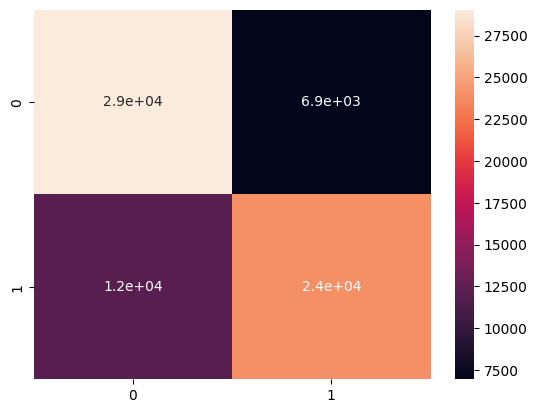

In [83]:
sns.heatmap(cm, annot=True)

Essa matriz fornece informações sobre o desempenho do modelo de classificação, permitindo uma análise de falsos positivos, falsos negativos e acertos em cada classe. A partir dessa matriz concluímos que:

A classe verdadeira 0 foi corretamente classificada em 24.568 Ex. (verdadeiros negativos), enquanto foi erroneamente classificada como classe 1 em 11.432 Ex. (falsos positivos).
A classe verdadeira 1 foi corretamente classificada em 27.959 Ex. (verdadeiros positivos), enquanto foi erroneamente classificada como classe 0 em 8.041 Ex. (falsos negativos).
Essas informações nos permitem avaliar o desempenho do modelo de classificação. Podemos observar que a classe verdadeira 0 possui uma quantidade maior de falsos positivos do que a classe verdadeira 1 tem de falsos negativos.

In [84]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

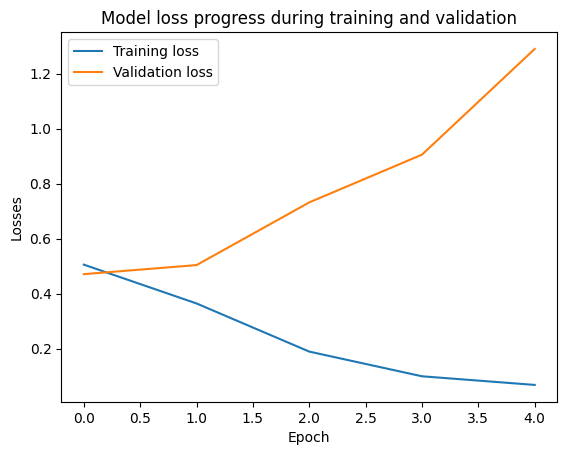

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Training loss', 'Validation loss'])

Na **base de dados de treinamento** o **valor do erro sempre foi baixando**, e na **base de dados de validação** o **valor do erro foi aumentando**.

No "history" do treinamento com número de épocas igual a cinco, o valor do erro na base de validação começou com 0.51 e aumentou para 1.39, então para melhorar o modelo, podem ser adotadas estratégias como ajuste de hiperparâmetros, regularização, aumento de dados ou até as mesmas mudanças na arquitetura do modelo. É importante realizar uma análise mais aprofundada dos dados, das características do modelo e dos resultados para determinar a melhor abordagem a ser seguida.

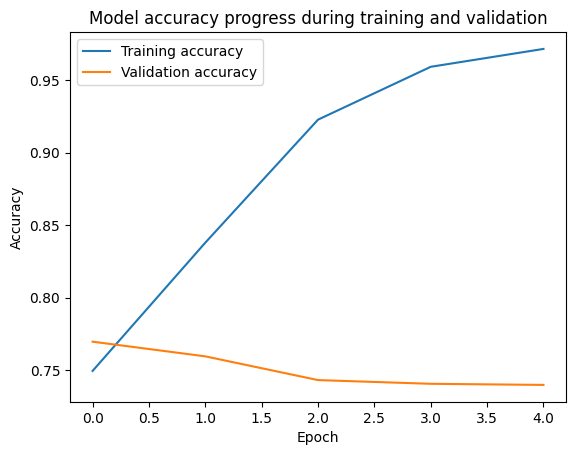

In [86]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])


Na **base de dados de treinamento**, observamos um **aumento contínuo na precisão** ao longo do treinamento do modelo. Por outro lado, na **base de dados de validação**, a **acurácia apresentou uma tendência de diminuição**.

Embora o valor de acurácia de **73%** na **base de dados de validação** não tenha sido tão bom em comparação com o percentual de acurácia de **97%** na **base de dados de treinamento**, é importante considerar alguns aspectos adicionais. Dado que temos apenas duas classes (Sentimento Positivo ou Sentimento Negativo) e uma base de dados consideravelmente grande, com 240.000 registros, a probabilidade aleatória de acertar cada classe seria de 50%.  Portanto, **podemos concluir que o resultado da acurácia de 73% não foi tão ruim, uma vez que está distante do percentual esperado de 50% da aleatoriedade**. Isso indica que o modelo possui algum grau de habilidade em realizar as melhores classificações do que se fosse uma escolha aleatória. No entanto, ainda há espaço para melhorias e refinamentos no modelo para aumentar sua acurácia na base de dados de validação. Podemos inferir que há indicações de **overfitting**, pois o modelo se ajusta nuito bem aos dados de treinamento, mas não generaliza bem para novos dados.


##5.2.Previsões

In [98]:

text = 'i love you'
text = tokenizer.encode(text)
text

[279, 13, 3813]

In [99]:
Dcnn(np.array([text]), training=False).numpy()

array([[0.99425316]], dtype=float32)

Ao fazermos uma **Previsão** com o texto "i love you", utlizando nossa **Rede Neural**, é retornado a probabilidade de 0.99 que é bem alta, indicando corretamente a Classe número 1 correspondente ao Sentimento Positivo, e assim **este algoritmo está fazendo a previsão correta**.